In [137]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

file_path = r"C:\Users\kimge\OneDrive\문서\Desktop\김 건\가천대학교\2025년 4학년 1학기_시간표\인공지능개론\6_week\diabetes\diabetes.csv"
df = pd.read_csv(file_path)

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: ylabel='count'>

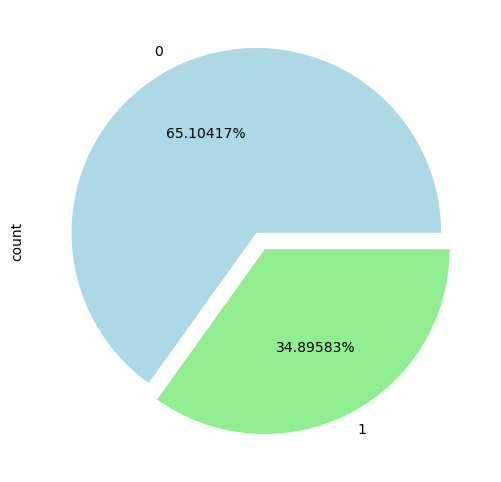

In [10]:
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
df['Outcome'].value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05))

In [12]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [14]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [19]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler() # Standardize the data
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [25]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [27]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [120]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(8, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1) # 결과가 2개로 나누어 지기 때문
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [122]:
model = ClassificationModel()

In [124]:
criterion = nn.BCEWithLogitsLoss() # 2진 분류
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [126]:
train_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        labels = labels.float().unsqueeze(1)  # [32] -> [32, 1] 2진분류이기 때문에 필요함 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 평균손실 정장
    train_losses.append(running_loss / len(train_dataloader))

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/20, Loss: 0.5877, Accuracy: 78.57%
Epoch 2/20, Loss: 0.4953, Accuracy: 83.12%
Epoch 3/20, Loss: 0.4673, Accuracy: 80.52%
Epoch 4/20, Loss: 0.4641, Accuracy: 80.52%
Epoch 5/20, Loss: 0.4452, Accuracy: 80.52%
Epoch 6/20, Loss: 0.4146, Accuracy: 80.52%
Epoch 7/20, Loss: 0.4545, Accuracy: 80.52%
Epoch 8/20, Loss: 0.4262, Accuracy: 81.82%
Epoch 9/20, Loss: 0.4234, Accuracy: 78.57%
Epoch 10/20, Loss: 0.4029, Accuracy: 82.47%
Epoch 11/20, Loss: 0.3886, Accuracy: 79.22%
Epoch 12/20, Loss: 0.3896, Accuracy: 78.57%
Epoch 13/20, Loss: 0.3389, Accuracy: 79.87%
Epoch 14/20, Loss: 0.3391, Accuracy: 74.68%
Epoch 15/20, Loss: 0.3296, Accuracy: 77.27%
Epoch 16/20, Loss: 0.3201, Accuracy: 77.92%
Epoch 17/20, Loss: 0.3131, Accuracy: 75.32%
Epoch 18/20, Loss: 0.3137, Accuracy: 78.57%
Epoch 19/20, Loss: 0.3005, Accuracy: 72.73%
Epoch 20/20, Loss: 0.2680, Accuracy: 77.27%


In [128]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy().reshape(-1))  # shape 일치

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 정확도 계산 함수들에 zero_division 추가 (경고 방지용)
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp + 1e-6))  # 0으로 나누는 경우 방지

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[87 20]
 [15 32]]
F1 Score: 0.78
Precision: 0.78
Recall: 0.77
Specificity: 0.75


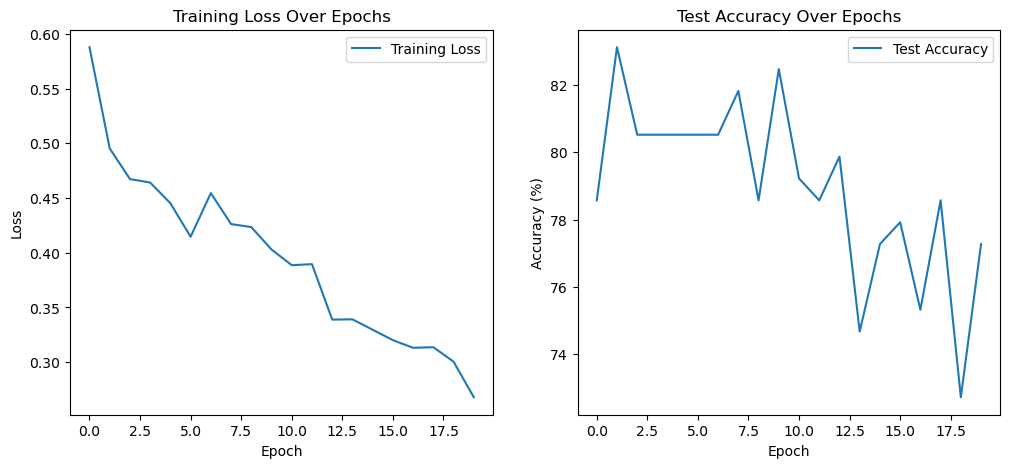

In [130]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()